In [50]:
json_prompt = """你精通python代码的静态检查相关的工具和原理，假设我拿到了python工具bandit扫描的结果，结果是json格式的，我需要分析这个结果从而确认是否误报，是否需要高优先级修复。
首先，请根据给出的json数据，帮我找出总共有多少高危（Severity = HIGH）、中危（Severity = MEDIUM）、低危（Severity = LOW）的漏洞。

json数据：
```json
{json_data}
```
"""

## **ssdlc 安全检查结果分析器**

### 步骤一，分析统计结果

In [51]:
from dotenv import load_dotenv, find_dotenv

_ = load_dotenv(find_dotenv("./env/.env"))

import dashscope
from http import HTTPStatus
from pprint import pprint
import json

from langchain.prompts import ChatPromptTemplate
from langchain_community.chat_models import ChatTongyi

llm_model = "qwen-max"

llm = ChatTongyi(temperature=1.0, model=llm_model)

json_analysis_prompt = ChatPromptTemplate.from_template(json_prompt)

with open("./data/result.json", "r") as f:
    json_data = json.load(f)

response = llm.invoke(json_analysis_prompt.format_messages(json_data=json_data))

print(response.content)

根据你提供的JSON数据，我们可以统计出不同严重程度（Severity）的漏洞数量。具体来说，我们需要查看`metrics`部分中每个文件对应的`SEVERITY.HIGH`、`SEVERITY.MEDIUM`和`SEVERITY.LOW`字段，并将它们汇总。

以下是Python代码来解析JSON数据并统计不同严重程度的漏洞数量：

```python
import json

# 假设你的JSON数据存储在一个字符串中
json_data = '''
{
    "errors": [],
    "generated_at": "2024-11-27T07:30:22Z",
    "metrics": {
        "./bench/__init__.py": {"SEVERITY.HIGH": 0, "SEVERITY.MEDIUM": 0, "SEVERITY.LOW": 0},
        "./bench/bench.py": {"SEVERITY.HIGH": 0, "SEVERITY.MEDIUM": 0, "SEVERITY.LOW": 0},
        "./bench/common/__init__.py": {"SEVERITY.HIGH": 0, "SEVERITY.MEDIUM": 0, "SEVERITY.LOW": 0},
        "./bench/common/config.py": {"SEVERITY.HIGH": 0, "SEVERITY.MEDIUM": 0, "SEVERITY.LOW": 0},
        "./bench/common/system.py": {"SEVERITY.HIGH": 1, "SEVERITY.MEDIUM": 0, "SEVERITY.LOW": 1},
        "./bench/controller/__init__.py": {"SEVERITY.HIGH": 0, "SEVERITY.MEDIUM": 0, "SEVERITY.LOW": 0},
        "./bench/controller/benchmark.py": {"SEVERITY.HIGH": 0, "SEVERITY.MEDIUM": 0, "SEVERITY.LOW"

### 步骤二，提取高危扫描结果


In [53]:
high_risk_prompt = """你精通python代码的静态检查相关的工具和原理，假设我拿到了python工具bandit扫描的结果，结果是json格式的，我需要分析这个结果从而确认是否误报，是否需要高优先级修复。扫描结果格式如下所示：
```json
{{
  "error": [<检查工具报错问题列表>],
  "generated_at": "<生成报告的时间>",
  "metrics": {{
    "<文件名1>": {{
      "CONFIDENCE.HIGH": <当前文件中扫描出的问题信心指数高的个数>,
      "CONFIDENCE.LOW": <当前文件中扫描出的问题信心指数低的个数>,
      "CONFIDENCE.MEDIUM":<当前文件中扫描出的问题信心指数中的个数>,
      "CONFIDENCE.UNDEFINED": <当前文件中扫描出的问题信心指数不确定的个数>,
      "SEVERITY.HIGH": <当前文件中扫描出的问题严重性高的个数>,
      "SEVERITY.LOW": <当前文件中扫描出的问题严重性低的个数>,
      "SEVERITY.MEDIUM": <当前文件中扫描出的问题严重性的中的个数>,
      "SEVERITY.UNDEFINED": <当前文件中扫描出的问题严重性不确定的个数>,
      "loc": <当前文件代码行数>,
      "nosec": <当前文件nosec打标数量>,
      "skipped_tests": <当前文件跳过的测试数量>
    }},
    "<文件名2>": {{...}},
    ...
    "<文件名n>": {{...}},
    "_totals": {{
      "CONFIDENCE.HIGH": <所有文件中扫描出的问题信心指数高的个数>,
      "CONFIDENCE.LOW": <所有文件中扫描出的问题信心指数低的个数>,
      "CONFIDENCE.MEDIUM":<所有文件中扫描出的问题信心指数中的个数>,
      "CONFIDENCE.UNDEFINED": <所有文件中扫描出的问题信心指数不确定的个数>,
      "SEVERITY.HIGH": <所有文件中扫描出的问题严重性高的个数>,
      "SEVERITY.LOW": <所有文件中扫描出的问题严重性低的个数>,
      "SEVERITY.MEDIUM": <所有文件中扫描出的问题严重性的中的个数>,
      "SEVERITY.UNDEFINED": <所有文件中扫描出的问题严重性不确定的个数>,
      "loc": <所有文件代码行数>,
      "nosec": <所有文件nosec打标数量>,
      "skipped_tests": <所有文件跳过的测试数量>
    }},
    "results":[<检查工具扫描出的问题列表>
    <example>
    {{
      "code": "3 import json\n4 import requests\n5 import subprocess\n6 import logging\n7 \n",
      "col_offset": 0,
      "end_col_offset": 17,
      "filename": "./bench/common/system.py",
      "issue_confidence": "HIGH",
      "issue_cwe": {{
        "id": 78,
        "link": "https://cwe.mitre.org/data/definitions/78.html"
      }},
      "issue_severity": "LOW",
      "issue_text": "Consider possible security implications associated with the subprocess module.",
      "line_number": 5,
      "line_range": [
        5
      ],
      "more_info": "https://bandit.readthedocs.io/en/1.8.0/blacklists/blacklist_imports.html#b404-import-subprocess",
      "test_id": "B404",
      "test_name": "blacklist"
    }}
    </example>
    ]
  }}
}}
```

你需要做的事情是：
1.请根据给出的json数据，帮我找出总共有多少高危（Severity = HIGH）、中危（Severity = MEDIUM）、低危（Severity = LOW）的漏洞。
2.输出扫描结果中高危的问题列表。
3.根据扫描结果中metrics记录，帮我找出扫描结果中，存在高危漏洞的文件列表。

要求：
1.根据我的要求帮我完成上述任务，不要做其他事情。
2.不需要输出任何解释，只需要按照我的要求做完事就好。
3.输出必须是json格式，包括扫描结果的总数量和问题列表。
4.输出结果不需要包括```json, ```这样符号。
5.输出格式如下：
```json
{{
  "total_vulnerabilities":{{
    "high_severity": <高危问题数量>,
    "medium_severity": <中危问题数量>,
    "low_severity": <低危问题数量>,
  }},
  "high_severity_issues": [
    {{
      "code": <问题代码>,
      "col_offset": <问题的描述>,
      "end_col_offset": <问题的严重程度>,
      "filename": <问题的修复建议>,
      "issue_confidence": <参考资料链接>,
      "issue_cwe": {{
        "id": <CWE编号>,
        "name": <CWE名称>
      }},
      "issue_severity": <问题严重等级>,
      "issue_text": <问题描述>,
      "line_range": <问题所在行>,
      "more_info": <问题修复建议>,
      "test_id": <问题类型>,
      "test_name": <问题类型名称>
    }},
    ...
  ],
  "files_with_high_severity_issues": [
    <文件路径>,
    ...
  ],
}}
```

json数据：
```json
{json_data}
```
"""

high_risk_analysis_prompt = ChatPromptTemplate.from_template(high_risk_prompt)

response = llm.invoke(high_risk_analysis_prompt.format_messages(json_data=json_data))

high_risk = response.content
pprint("".join(high_risk))

('{\n'
 '  "total_vulnerabilities": {\n'
 '    "high_severity": 1,\n'
 '    "medium_severity": 0,\n'
 '    "low_severity": 3\n'
 '  },\n'
 '  "high_severity_issues": [\n'
 '    {\n'
 '      "code": "37     result = subprocess.run(\\n38         '
 'command,\\n39         shell=True,\\n40         close_fds=True,\\n41         '
 'cwd=cwd,\\n42         stderr=subprocess.PIPE,\\n43         '
 'stdout=subprocess.PIPE\\n44     )\\n45 \\n46     suc = (result.returncode == '
 "0)\\n47     out = result.stdout.decode('UTF-8', 'strict').strip()\\n48     "
 'error = result.stderr.decode(\'UTF-8\', \'strict\').strip()\\n",\n'
 '      "col_offset": 13,\n'
 '      "end_col_offset": 5,\n'
 '      "filename": "./bench/common/system.py",\n'
 '      "issue_confidence": "HIGH",\n'
 '      "issue_cwe": {\n'
 '        "id": 78,\n'
 '        "name": "Improper Neutralization of Special Elements used in an OS '
 'Command (\'OS Command Injection\')"\n'
 '      },\n'
 '      "issue_severity": "HIGH",\n'
 '      "i

### 步骤三，提取高危问题源码和CWE信息

In [ ]:
risk_data = json.loads(high_risk)
risk_code = risk_data["high_severity_issues"][0]["code"]

import os
source_code_path = os.path.join(
    "./data", "keentune-bench-3.0.0", risk_data["files_with_high_severity_issues"][0]
)
cwd_78_path = os.path.join("./data", "cwe-78.md")

source_code = open(source_code_path, "r").read()
cwe_78 = open(cwd_78_path, "r").read()
from IPython.display import display,Markdown
display(Markdown(
f"""```python
{risk_code}
```
---
```python
{source_code}
```

{cwe_78[:100]}
"""))

```python
37     result = subprocess.run(
38         command,
39         shell=True,
40         close_fds=True,
41         cwd=cwd,
42         stderr=subprocess.PIPE,
43         stdout=subprocess.PIPE
44     )
45 
46     suc = (result.returncode == 0)
47     out = result.stdout.decode('UTF-8', 'strict').strip()
48     error = result.stderr.decode('UTF-8', 'strict').strip()

```
---
```python
# Copyright (c) 2021-2023 Alibaba Cloud Computing Ltd.
# SPDX-License-Identifier: MulanPSL-2.0
import json
import requests
import subprocess
import logging

logger = logging.getLogger('common')


def proc_alive(pid):
    try:
        os.kill(pid, 0)
        return True
    except:
        return False


def httpResponse(response_data, response_ip, response_port):
    logger.info("send response to {ip}:{port}:{data}".format(
        ip = response_ip,
        port = response_port,
        data = response_data
    ))
    try:
        requests.post(
            url = "http://{ip}:{port}/benchmark_result".format(ip = response_ip, port = response_port),
            data = json.dumps(response_data),
            timeout = 3)
    except requests.exceptions.ConnectTimeout:
        logger.warning("send response timeout: ip = {}, port = {}".format(response_ip, response_port))
        
        
def sysCommand(command: str, cwd: str = "./"):
    '''Run system command with subprocess.run and return result
    '''
    result = subprocess.run(
        command,
        shell=True,
        close_fds=True,
        cwd=cwd,
        stderr=subprocess.PIPE,
        stdout=subprocess.PIPE
    )

    suc = (result.returncode == 0)
    out = result.stdout.decode('UTF-8', 'strict').strip()
    error = result.stderr.decode('UTF-8', 'strict').strip()

    if not suc:
        return suc, error
    else:
        return suc, out


def checkAddressAvaliable(address_list: list):
    result = {}
    for ip in address_list:
        logger.debug("ping -W 1 -c 1 {}".format(ip))
        try:
            suc, _ = sysCommand("ping -W 1 -c 1 {ip}".format(ip = ip))
            if not suc:
                logger.warning("Failed to ping {}".format(ip))
            else:
                logger.debug("Success to ping {}".format(ip))
            result[ip] = suc
        
        except Exception as e:
            logger.error("fail to ping {}: {}".format(ip, e))
            result[ip] = False

    return result

```

## CWE-78: Improper Neutralization of Special Elements used in an OS Command ('OS Command Injection'


## CWE-78: Improper Neutralization of Special Elements used in an OS Command ('OS Command Injection')
--------------------------------------------------------------------------------------------------

Weakness ID: 78

------------------

### Description

The product constructs all or part of an OS command using externally-influenced input from an upstream component, but it does not neutralize or incorrectly neutralizes special elements that could modify the intended OS command when it is sent to a downstream component.


### Extended Description

This weakness can lead to a vulnerability in environments in which the attacker does not have direct access to the operating system, such as in web applications. Alternately, if the weakness occurs in a privileged program, it could allow the attacker to specify commands that normally would not be accessible, or to call alternate commands with privileges that the attacker does not have. The problem is exacerbated if the compromised process does not follow the principle of least privilege, because the attacker-controlled commands may run with special system privileges that increases the amount of damage.

There are at least two subtypes of OS command injection:

*   The application intends to execute a single, fixed program that is under its own control. It intends to use externally-supplied inputs as arguments to that program. For example, the program might use system("nslookup \[HOSTNAME\]") to run nslookup and allow the user to supply a HOSTNAME, which is used as an argument. Attackers cannot prevent nslookup from executing. However, if the program does not remove command separators from the HOSTNAME argument, attackers could place the separators into the arguments, which allows them to execute their own program after nslookup has finished executing.
*   The application accepts an input that it uses to fully select which program to run, as well as which commands to use. The application simply redirects this entire command to the operating system. For example, the program might use "exec(\[COMMAND\])" to execute the \[COMMAND\] that was supplied by the user. If the COMMAND is under attacker control, then the attacker can execute arbitrary commands or programs. If the command is being executed using functions like exec() and CreateProcess(), the attacker might not be able to combine multiple commands together in the same line.

From a weakness standpoint, these variants represent distinct programmer errors. In the first variant, the programmer clearly intends that input from untrusted parties will be part of the arguments in the command to be executed. In the second variant, the programmer does not intend for the command to be accessible to any untrusted party, but the programmer probably has not accounted for alternate ways in which malicious attackers can provide input.

### Alternate Terms

* Shell injection

* Shell metacharacters

* OS Command Injection

### Common Consequences

|Scope|Impact|Likelihood|
|--|--|--|
|Confidentiality<br>Integrity<br>Availability<br>Non-Repudiation|Technical Impact: _Execute Unauthorized Code or Commands; DoS: Crash, Exit, or Restart; Read Files or Directories; Modify Files or Directories; Read Application Data; Modify Application Data; Hide Activities_<br>Attackers could execute unauthorized operating system commands, which could then be used to disable the product, or read and modify data for which the attacker does not have permissions to access directly. Since the targeted application is directly executing the commands instead of the attacker, any malicious activities may appear to come from the application or the application's owner.|-|

### Potential Mitigations

#### Phase: Architecture and Design

If at all possible, use library calls rather than external processes to recreate the desired functionality.

#### Phases: Architecture and Design; Operation

**Strategy: Sandbox or Jail**

Run the code in a "jail" or similar sandbox environment that enforces strict boundaries between the process and the operating system. This may effectively restrict which files can be accessed in a particular directory or which commands can be executed by the software.

OS-level examples include the Unix chroot jail, AppArmor, and SELinux. In general, managed code may provide some protection. For example, java.io.FilePermission in the Java SecurityManager allows the software to specify restrictions on file operations.

This may not be a feasible solution, and it only limits the impact to the operating system; the rest of the application may still be subject to compromise.

Be careful to avoid [CWE-243](/data/definitions/243.html) and other weaknesses related to jails.

**Effectiveness: Limited**

**Note:** The effectiveness of this mitigation depends on the prevention capabilities of the specific sandbox or jail being used and might only help to reduce the scope of an attack, such as restricting the attacker to certain system calls or limiting the portion of the file system that can be accessed.

#### Phase: Architecture and Design

**Strategy: Attack Surface Reduction**

For any data that will be used to generate a command to be executed, keep as much of that data out of external control as possible. For example, in web applications, this may require storing the data locally in the session's state instead of sending it out to the client in a hidden form field.

#### Phase: Architecture and Design

For any security checks that are performed on the client side, ensure that these checks are duplicated on the server side, in order to avoid [CWE-602](/data/definitions/602.html). Attackers can bypass the client-side checks by modifying values after the checks have been performed, or by changing the client to remove the client-side checks entirely. Then, these modified values would be submitted to the server.

#### Phase: Architecture and Design

**Strategy: Libraries or Frameworks**

Use a vetted library or framework that does not allow this weakness to occur or provides constructs that make this weakness easier to avoid.

For example, consider using the ESAPI Encoding control \[[REF-45](#REF-45_78)\] or a similar tool, library, or framework. These will help the programmer encode outputs in a manner less prone to error.

#### Phase: Implementation

**Strategy: Output Encoding**

While it is risky to use dynamically-generated query strings, code, or commands that mix control and data together, sometimes it may be unavoidable. Properly quote arguments and escape any special characters within those arguments. The most conservative approach is to escape or filter all characters that do not pass an extremely strict allowlist (such as everything that is not alphanumeric or white space). If some special characters are still needed, such as white space, wrap each argument in quotes after the escaping/filtering step. Be careful of argument injection ([CWE-88](/data/definitions/88.html)).

#### Phase: Implementation

If the program to be executed allows arguments to be specified within an input file or from standard input, then consider using that mode to pass arguments instead of the command line.

#### Phase: Architecture and Design

**Strategy: Parameterization**

If available, use structured mechanisms that automatically enforce the separation between data and code. These mechanisms may be able to provide the relevant quoting, encoding, and validation automatically, instead of relying on the developer to provide this capability at every point where output is generated.

Some languages offer multiple functions that can be used to invoke commands. Where possible, identify any function that invokes a command shell using a single string, and replace it with a function that requires individual arguments. These functions typically perform appropriate quoting and filtering of arguments. For example, in C, the system() function accepts a string that contains the entire command to be executed, whereas execl(), execve(), and others require an array of strings, one for each argument. In Windows, CreateProcess() only accepts one command at a time. In Perl, if system() is provided with an array of arguments, then it will quote each of the arguments.

#### Phase: Implementation

**Strategy: Input Validation**

Assume all input is malicious. Use an "accept known good" input validation strategy, i.e., use a list of acceptable inputs that strictly conform to specifications. Reject any input that does not strictly conform to specifications, or transform it into something that does.

When performing input validation, consider all potentially relevant properties, including length, type of input, the full range of acceptable values, missing or extra inputs, syntax, consistency across related fields, and conformance to business rules. As an example of business rule logic, "boat" may be syntactically valid because it only contains alphanumeric characters, but it is not valid if the input is only expected to contain colors such as "red" or "blue."

Do not rely exclusively on looking for malicious or malformed inputs. This is likely to miss at least one undesirable input, especially if the code's environment changes. This can give attackers enough room to bypass the intended validation. However, denylists can be useful for detecting potential attacks or determining which inputs are so malformed that they should be rejected outright.

When constructing OS command strings, use stringent allowlists that limit the character set based on the expected value of the parameter in the request. This will indirectly limit the scope of an attack, but this technique is less important than proper output encoding and escaping.

Note that proper output encoding, escaping, and quoting is the most effective solution for preventing OS command injection, although input validation may provide some defense-in-depth. This is because it effectively limits what will appear in output. Input validation will not always prevent OS command injection, especially if you are required to support free-form text fields that could contain arbitrary characters. For example, when invoking a mail program, you might need to allow the subject field to contain otherwise-dangerous inputs like ";" and ">" characters, which would need to be escaped or otherwise handled. In this case, stripping the character might reduce the risk of OS command injection, but it would produce incorrect behavior because the subject field would not be recorded as the user intended. This might seem to be a minor inconvenience, but it could be more important when the program relies on well-structured subject lines in order to pass messages to other components.

Even if you make a mistake in your validation (such as forgetting one out of 100 input fields), appropriate encoding is still likely to protect you from injection-based attacks. As long as it is not done in isolation, input validation is still a useful technique, since it may significantly reduce your attack surface, allow you to detect some attacks, and provide other security benefits that proper encoding does not address.

#### Phase: Architecture and Design

**Strategy: Enforcement by Conversion**

When the set of acceptable objects, such as filenames or URLs, is limited or known, create a mapping from a set of fixed input values (such as numeric IDs) to the actual filenames or URLs, and reject all other inputs.

#### Phase: Operation

**Strategy: Compilation or Build Hardening**

Run the code in an environment that performs automatic taint propagation and prevents any command execution that uses tainted variables, such as Perl's "-T" switch. This will force the program to perform validation steps that remove the taint, although you must be careful to correctly validate your inputs so that you do not accidentally mark dangerous inputs as untainted (see [CWE-183](/data/definitions/183.html) and [CWE-184](/data/definitions/184.html)).

#### Phase: Operation

**Strategy: Environment Hardening**

Run the code in an environment that performs automatic taint propagation and prevents any command execution that uses tainted variables, such as Perl's "-T" switch. This will force the program to perform validation steps that remove the taint, although you must be careful to correctly validate your inputs so that you do not accidentally mark dangerous inputs as untainted (see [CWE-183](/data/definitions/183.html) and [CWE-184](/data/definitions/184.html)).

#### Phase: Implementation

Ensure that error messages only contain minimal details that are useful to the intended audience and no one else. The messages need to strike the balance between being too cryptic (which can confuse users) or being too detailed (which may reveal more than intended). The messages should not reveal the methods that were used to determine the error. Attackers can use detailed information to refine or optimize their original attack, thereby increasing their chances of success.

If errors must be captured in some detail, record them in log messages, but consider what could occur if the log messages can be viewed by attackers. Highly sensitive information such as passwords should never be saved to log files.

Avoid inconsistent messaging that might accidentally tip off an attacker about internal state, such as whether a user account exists or not.

In the context of OS Command Injection, error information passed back to the user might reveal whether an OS command is being executed and possibly which command is being used.

#### Phase: Operation

**Strategy: Sandbox or Jail**

Use runtime policy enforcement to create an allowlist of allowable commands, then prevent use of any command that does not appear in the allowlist. Technologies such as AppArmor are available to do this.

#### Phase: Operation

**Strategy: Firewall**

Use an application firewall that can detect attacks against this weakness. It can be beneficial in cases in which the code cannot be fixed (because it is controlled by a third party), as an emergency prevention measure while more comprehensive software assurance measures are applied, or to provide defense in depth.

**Effectiveness: Moderate**

**Note:** An application firewall might not cover all possible input vectors. In addition, attack techniques might be available to bypass the protection mechanism, such as using malformed inputs that can still be processed by the component that receives those inputs. Depending on functionality, an application firewall might inadvertently reject or modify legitimate requests. Finally, some manual effort may be required for customization.

#### Phases: Architecture and Design; Operation

**Strategy: Environment Hardening**

Run your code using the lowest privileges that are required to accomplish the necessary tasks \[[REF-76](#REF-76_78)\]. If possible, create isolated accounts with limited privileges that are only used for a single task. That way, a successful attack will not immediately give the attacker access to the rest of the software or its environment. For example, database applications rarely need to run as the database administrator, especially in day-to-day operations.

#### Phases: Operation; Implementation

**Strategy: Environment Hardening**

When using PHP, configure the application so that it does not use register\_globals. During implementation, develop the application so that it does not rely on this feature, but be wary of implementing a register\_globals emulation that is subject to weaknesses such as [CWE-95](/data/definitions/95.html), [CWE-621](/data/definitions/621.html), and similar issues.

### 步骤四，提取高危源码的调用关系

根据你提供的信息，我们可以逐步分析并解决这个问题。

### 1. 找出问题代码段在源码文件中属于哪个函数

首先，我们来看一下高危问题的代码段：
```python
37     result = subprocess.run(
38         command,
39         shell=True,
40         close_fds=True,
41         cwd=cwd,
42         stderr=subprocess.PIPE,
43         stdout=subprocess.PIPE
44     )
45 
46     suc = (result.returncode == 0)
47     out = result.stdout.decode('UTF-8', 'strict').strip()
48     error = result.stderr.decode('UTF-8', 'strict').strip()
```

通过对比源码内容，可以发现这段代码位于 `sysCommand` 函数中。具体如下：
```python
def sysCommand(command: str, cwd: str = "./"):
    '''Run system command with subprocess.run and return result
    '''
    result = subprocess.run(
        command,
        shell=True,
        close_fds=True,
        cwd=cwd,
        stderr=subprocess.PIPE,
        stdout=subprocess.PIPE
    )

    suc = (result.returncode == 0)
    out = result.stdout.decode('UTF-8', 'strict').strip()
    error = result.stderr.decode('UTF-8', 'strict').strip()

    if not suc:
        return suc, error


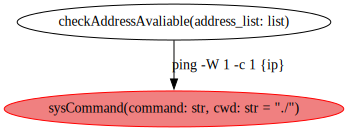

In [72]:
parse_high_risk_call_graph_template = """你是一个精通python语言分析的专家，我会给你一段含有python代码高危问题的json数据，数据格式为：
```json
{{
  "total_vulnerabilities":{{
    "high_severity": <高危问题数量>,
    "medium_severity": <中危问题数量>,
    "low_severity": <低危问题数量>,
  }},
  "high_severity_issues": [
    {{
      "code": <问题代码>,
      "col_offset": <问题的描述>,
      "end_col_offset": <问题的严重程度>,
      "filename": <问题的修复建议>,
      "issue_confidence": <参考资料链接>,
      "issue_cwe": {{
        "id": <CWE编号>,
        "name": <CWE名称>
      }},
      "issue_severity": <问题严重等级>,
      "issue_text": <问题描述>,
      "line_range": <问题所在行>,
      "more_info": <问题修复建议>,
      "test_id": <问题类型>,
      "test_name": <问题类型名称>
    }},
    ...
  ],
  "files_with_high_severity_issues": [
    <文件路径>,
    ...
  ],
}}
```

python代码高危问题json数据为：
{high_risk}

同时我还会提供源码内容{source_code}以供你进行python的分析。

你需要做的事情是：
1.找出问题代码段在源码文件中属于哪个函数
2.找出第1步中函数调用链
"""

parse_high_risk_call_graph_prompt = ChatPromptTemplate.from_template(
    parse_high_risk_call_graph_template
)

response = llm.invoke(
    parse_high_risk_call_graph_prompt.format_messages(high_risk=high_risk, source_code=source_code)
)

high_risk_call_graph = response.content

print(high_risk_call_graph)


dot_graph_description = """你是一个精通DOT语言描述代码调用关系图（call graph）的专家，请根据我给出的python代码高危问题json数据和高危问题所在函数及其调用点数据，用dot语言描述该代码调用关系图。

**要求：**
1.你不需要做其他任何事情，只需要用dot语言把代码调用关系图出来就可以；
2.你可以根据自己对dot语言的理解进行编写生成dot语言描述，但请确保你的描述符合dot语言语法，并且能正确描述出代码调用关系图；
3.你的描述需要包含函数名、函数参数、函数返回值、函数调用链等必要信息，但不要包含函数体；
4.生成的内容除了dot语言之外不要包括其他任何内容，也不要包含```dot和```这类非dot语言语法的内容；


python代码高危问题json数据为：
{high_risk}

高危问题所在函数及其调用点数据为：
{high_risk_call_graph}
"""
dot_graph_prompt = ChatPromptTemplate.from_template(dot_graph_description)

response = llm.invoke(
    dot_graph_prompt.format_messages(high_risk=high_risk, high_risk_call_graph=high_risk_call_graph)
)

dot_graph = response.content

print(dot_graph)

from graphviz import Source
from IPython.display import SVG, display

dot_call_graph = Source(dot_graph, filename="output-graph.gv", format="svg")
display(SVG(dot_call_graph.pipe().decode("utf-8")))

### 步骤五，CWE危险等级分析

In [75]:
cwe_severity_analysis_template = """你是一个精通python语言的安全工程师，你精通CWE漏洞的利用。我会给出一段有高危问题的源码和高危问题所在函数的调用链，同时我还会给出高危问题的CWE信息，
CWE信息包括：
- CWE名称
- CWE编号（Weakness ID）
- CWE描述（Description， Extended Description）
- CWE常见的后果（Common Consequence）
- CWE修复建议（Potential Mitigations），修复建议会根据不同阶段Phase给出办法，例如：架构设计阶段Phase: Architecture and Design

你的任务是根据CWE信息对高危问题进行分析：
1.根据高危问题以及其函数调用链的信息，结合CWE信息，给出该问题的影响和后果；
2.根据函数调用链信息以及源码，结合CWE描述和修复建议等信息，给出该高危问题被外部调用者利用的可能性和难易程度；
3.根据CWE的修复建议、函数调用链、该高危问题被利用的可能性和难易程度，给出该高危问题的修复建议；
4.根据上面步骤1，2，3的分析结果，给出该高危问题的分析总结；

要求：
- 输出结果的标题为"SSDLC高危问题分析报告"；
- 需要按照分析过程进行内容输出，包括：1.问题的影响和后果；2.利用的可能性和难易程度；3.修复建议；4.分析总结；
- 输出结果时需要按照分析过程包括你使用的数据来源，分析方法，以及你如何结合CWE信息对问题的影响和后果进行评估；
- 给出的修复建议中要考虑函数调用链上每个函数的参数和返回值；
- 为了方便快速识别和理解该高危问题，高危问题分析总结中，根据该高危问题被外部调用者利用的可能性是由高到低、难易程度由容易到困难以及修复问题的难度由简单到困难，给出总结评估打分；

高危问题所在源码：
```python
{source_code}
```

高危问题所在函数调用链情况：
```python
{high_risk_call_graph}
```

CWE信息如下：
```markdown
{cwe_info}
```
"""

cwe_severity_analysis_prompt = ChatPromptTemplate.from_template(
    cwe_severity_analysis_template
)

response = llm.invoke(
    cwe_severity_analysis_prompt.format_messages(
        source_code=source_code,
        high_risk_call_graph=high_risk_call_graph,
        cwe_info=cwe_78,
    )
)

cwe_severity_analysis = response.content

### 步骤六，生成ssdlc扫描分析报告

In [76]:
display(Markdown(cwe_severity_analysis))

# SSDLC高危问题分析报告

## 1. 问题的影响和后果

### CWE-78: 不正确的中和用于OS命令的特殊元素（'OS命令注入'）

**CWE编号**: 78

**描述**:
该产品使用来自上游组件的外部影响输入构造全部或部分OS命令，但未中和或错误地处理了可能在发送到下游组件时修改预期OS命令的特殊元素。

**扩展描述**:
此弱点可能导致在攻击者无法直接访问操作系统的环境中出现漏洞，例如在Web应用程序中。或者，如果该弱点出现在特权程序中，它可能允许攻击者指定通常无法访问的命令，或以攻击者没有的权限调用其他命令。如果被破坏的进程不遵循最小权限原则，则问题会更加严重，因为攻击者控制的命令可能会以特殊的系统权限运行，从而增加损害程度。

**常见的后果**:
- **机密性**: 攻击者可以执行未经授权的操作系统命令，这些命令可用于禁用产品，读取和修改数据。
- **完整性**: 攻击者可以修改文件或目录中的数据。
- **可用性**: 攻击者可以导致系统崩溃、退出或重启。
- **不可否认性**: 由于目标应用程序直接执行命令而不是攻击者，任何恶意活动可能看起来来自应用程序或应用程序的所有者。

### 影响和后果分析
在 `sysCommand` 函数中，`command` 参数是直接从调用者传递过来的，并且通过 `subprocess.run` 执行。如果 `command` 参数包含恶意输入，攻击者可以注入任意命令，导致以下后果：
- **执行未经授权的命令**：攻击者可以执行任意操作系统命令，如删除文件、安装恶意软件等。
- **拒绝服务 (DoS)**：攻击者可以通过注入导致系统崩溃或挂起的命令来使系统不可用。
- **数据泄露**：攻击者可以读取敏感文件或目录，获取机密信息。
- **数据篡改**：攻击者可以修改文件或目录中的数据，破坏数据完整性。

## 2. 利用的可能性和难易程度

### 调用链分析
- `checkAddressAvaliable` 调用了 `sysCommand` 函数。
- `sysCommand` 函数接收一个 `command` 参数，并通过 `subprocess.run` 执行。

### 利用的可能性
- **可能性**：高。`checkAddressAvaliable` 函数中的 `ip` 参数直接拼接到 `ping` 命令中，如果 `ip` 参数包含恶意输入，可以直接注入命令。
- **难易程度**：容易。攻击者只需提供一个包含恶意命令的 `ip` 参数即可利用该漏洞。

### 利用的具体步骤
1. 攻击者向 `checkAddressAvaliable` 函数传递一个恶意的 `ip` 参数，例如 `"192.168.1.1; rm -rf /"`.
2. `checkAddressAvaliable` 函数将该参数传递给 `sysCommand` 函数。
3. `sysCommand` 函数通过 `subprocess.run` 执行包含恶意命令的 `ping` 命令。
4. 恶意命令被执行，导致系统被破坏或数据被篡改。

## 3. 修复建议

### 修复建议
根据CWE-78的修复建议，结合函数调用链和利用的可能性及难易程度，提出以下修复建议：

#### 1. 使用库调用替代外部进程
- **Phase: Architecture and Design**
  - 如果可能，使用库调用来替代外部进程，以实现所需的功能。例如，使用 `socket` 库来检查IP地址是否可达，而不是使用 `ping` 命令。

#### 2. 输入验证
- **Phase: Implementation**
  - 对所有输入进行严格的验证。确保 `ip` 参数只包含有效的IP地址格式。可以使用正则表达式或其他验证方法来确保输入的有效性。
  - 代码示例：
    ```python
    import re

    def validate_ip(ip):
        pattern = r'^(\d{1,3}\.){3}\d{1,3}$'
        if not re.match(pattern, ip):
            raise ValueError("Invalid IP address")
        return ip

    def checkAddressAvaliable(address_list: list):
        result = {}
        for ip in address_list:
            try:
                ip = validate_ip(ip)
                logger.debug(f"ping -W 1 -c 1 {ip}")
                suc, _ = sysCommand(f"ping -W 1 -c 1 {ip}")
                if not suc:
                    logger.warning(f"Failed to ping {ip}")
                else:
                    logger.debug(f"Success to ping {ip}")
                result[ip] = suc
            except Exception as e:
                logger.error(f"fail to ping {ip}: {e}")
                result[ip] = False
        return result
    ```

#### 3. 参数化
- **Phase: Architecture and Design**
  - 使用结构化的机制来自动强制分离数据和代码。例如，在Python中，可以使用 `subprocess.Popen` 并传递参数列表，而不是单个字符串。
  - 代码示例：
    ```python
    def sysCommand(command: str, cwd: str = "./"):
        '''Run system command with subprocess.run and return result
        '''
        args = command.split()
        result = subprocess.run(
            args,
            close_fds=True,
            cwd=cwd,
            stderr=subprocess.PIPE,
            stdout=subprocess.PIPE
        )

        suc = (result.returncode == 0)
        out = result.stdout.decode('UTF-8', 'strict').strip()
        error = result.stderr.decode('UTF-8', 'strict').strip()

        if not suc:
            return suc, error
        else:
            return suc, out
    ```

#### 4. 环境加固
- **Phase: Operation**
  - 运行代码时使用最低权限。创建隔离的账户，仅具有完成必要任务所需的最低权限。
  - 代码示例：
    ```python
    import os

    def sysCommand(command: str, cwd: str = "./"):
        '''Run system command with subprocess.run and return result
        '''
        # Drop privileges
        os.setuid(os.getuid())
        os.setgid(os.getgid())

        args = command.split()
        result = subprocess.run(
            args,
            close_fds=True,
            cwd=cwd,
            stderr=subprocess.PIPE,
            stdout=subprocess.PIPE
        )

        suc = (result.returncode == 0)
        out = result.stdout.decode('UTF-8', 'strict').strip()
        error = result.stderr.decode('UTF-8', 'strict').strip()

        if not suc:
            return suc, error
        else:
            return suc, out
    ```

## 4. 分析总结

### 总结评估打分
- **利用的可能性**：高
- **难易程度**：容易
- **修复难度**：简单

### 分析总结
- **问题的影响和后果**：高危问题可能导致执行未经授权的命令、拒绝服务、数据泄露和数据篡改。
- **利用的可能性和难易程度**：利用的可能性很高，且攻击者很容易通过提供恶意的 `ip` 参数来利用该漏洞。
- **修复建议**：建议通过严格的输入验证、参数化和环境加固来修复该问题。这些措施可以有效防止OS命令注入，并减少攻击面。

希望这份报告能帮助你更好地理解和解决这个问题。如果有更多问题，请随时告诉我。